# Call Annotations

In [11]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import liana as li

In [12]:
from utils import run_rf_auc

In [13]:
data_dir = os.path.join('..', '..', 'data', 'wu_et_al')
dataset_names = ['1160920F', 'CID44971', 'CID4535', '1142243F'] # 'CID4465', 'CID4290 are both basically cancer only

In [14]:
function_names = li.mt.bivar.show_functions()['name'].values

In [15]:
function_names

array(['pearson', 'spearman', 'cosine', 'jaccard', 'morans',
       'masked_spearman'], dtype=object)

Run on all data

In [6]:
for dataset_name in dataset_names:
    print(f"Running {dataset_name}")
    adata = sc.read_h5ad(os.path.join(data_dir, f"{dataset_name}.h5ad"))
    
    adata.uns['function_names'] = function_names
    
    # to binary
    adata.obs['Classification'][adata.obs['Classification'].isna()] = 'Artefact'
    adata.obs['spot_label'] = adata.obs['Classification'].str.contains('cancer').astype(int)
    
    # Preprocess
    sc.pp.filter_cells(adata, min_genes=400)
    sc.pp.filter_genes(adata, min_cells=20)

    adata.layers["counts"] = adata.X.copy()
    
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    
    # spatial weights
    li.ut.spatial_neighbors(adata, set_diag=True, bandwidth=150, cutoff=0.1)
    
    # Run all functions
    for function_name in function_names:
        print(f"Running {function_name}")
        
        li.mt.lr_bivar(adata,
                       function_name=function_name,
                       obsm_added=function_name, 
                       key_added= function_name,
                       use_raw=False, 
                       verbose=True,
                       n_perms=None,
                       # proximity_key="spatial_connectivities"
                       )
        
    # eval LR basis
    run_rf_auc(adata, dataset_name)
    os.makedirs(os.path.join(data_dir, 'results'), exist_ok=True)
    performance = adata.uns['performance']
    performance.to_csv(os.path.join(data_dir, 'results', f"{dataset_name}_performance.csv"))


Running 1160920F
Running pearson
Using resource `consensus`.
Using `.X`!
Converting mat to CSR format
Running spearman
Using resource `consensus`.
Using `.X`!
Converting mat to CSR format
Running cosine
Using resource `consensus`.
Using `.X`!
Converting mat to CSR format
Running jaccard
Using resource `consensus`.
Using `.X`!
Converting mat to CSR format
Running morans
Using resource `consensus`.
Using `.X`!
Converting mat to CSR format
Running masked_spearman
Using resource `consensus`.
Using `.X`!
Converting mat to CSR format
Evaluating 1160920F; Fold: 0
Evaluating 1160920F; Fold: 1
Evaluating 1160920F; Fold: 2
Evaluating 1160920F; Fold: 3
Evaluating 1160920F; Fold: 4
Evaluating 1160920F; Fold: 5
Evaluating 1160920F; Fold: 6
Evaluating 1160920F; Fold: 7
Evaluating 1160920F; Fold: 8
Evaluating 1160920F; Fold: 9
Running CID44971
Running pearson
Using resource `consensus`.
Using `.X`!
Converting mat to CSR format
Running spearman
Using resource `consensus`.
Using `.X`!
Converting mat to

Plot Results

In [16]:
import plotnine as p9

In [17]:
## read results
results = os.listdir(os.path.join(data_dir, 'results'))
results = [result for result in results if not result.__contains__('lig')]
results_df = []
for result in results:
    results_df.append(pd.read_csv(os.path.join(data_dir, 'results', result)))
results_df = pd.concat(results_df)

In [18]:
performance = results_df.groupby(['dataset_name', 'function_name']).mean().reset_index()

In [19]:
# rank by dataset_name
performance['rank'] = performance.groupby('dataset_name')['roc_auc'].rank(ascending=False).astype('int')

In [20]:
# Rename functions
name_dict = {'cosine': 'Cosine similarity',
             'jaccard': 'Jaccard index',
             'masked_spearman': 'Masked Spearman',
             'pearson': 'Pearson correlation',
             'morans': 'Moran\'s R',
             'spearman': 'Spearman correlation',
             }
performance['function_name'].replace(name_dict, inplace=True)

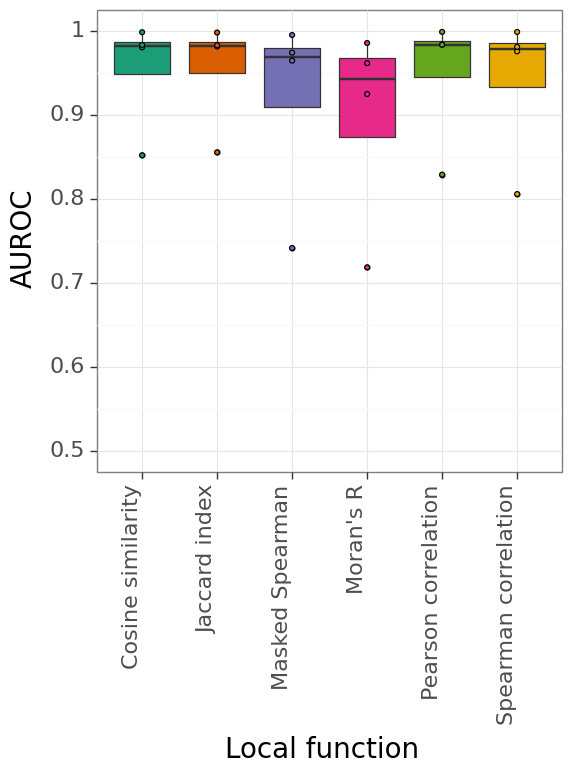

<ggplot: (8781315323382)>

In [21]:
# boxplot with dataset as shape
(p9.ggplot(performance, p9.aes(x='function_name', y='roc_auc', fill='function_name')) + 
 p9.geom_boxplot() + 
 p9.geom_point(p9.aes()) +
 # change cat palette of fill
 p9.scale_fill_brewer(type='qual', palette='Dark2') +
 p9.labs(x='Local function', y='AUROC') +
 p9.theme_bw(base_size=20) +
 p9.theme(axis_text_x=p9.element_text(rotation=90), figure_size=(6, 6)) +
 # rotate axis text
 p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1)) +
 # limits of y axis
 p9.scale_y_continuous(limits=(0.5, 1)) +
 # remove legend
 p9.theme(legend_title=p9.element_blank(), legend_position='none')
 )

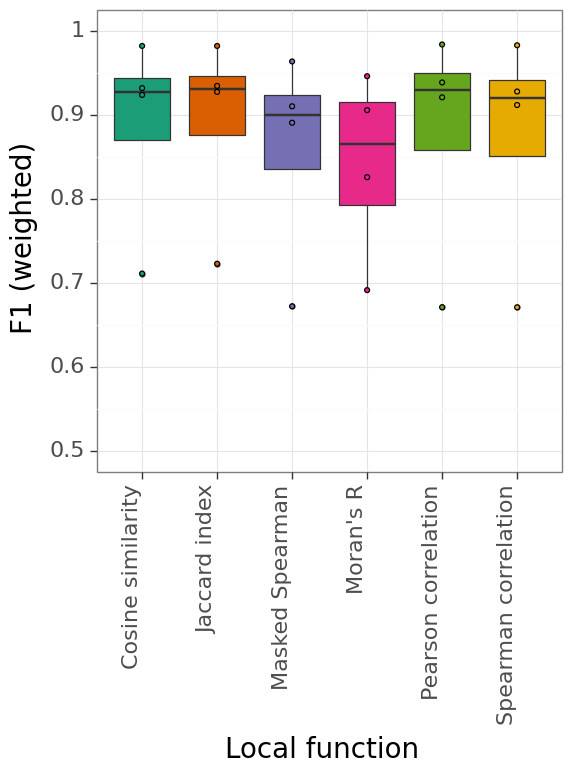

<ggplot: (8781315070331)>

In [22]:
# boxplot with dataset as shape
(p9.ggplot(performance, p9.aes(x='function_name', y='f1', fill='function_name')) + 
 p9.geom_boxplot() + 
 p9.geom_point(p9.aes()) +
 # change cat palette of fill
 p9.scale_fill_brewer(type='qual', palette='Dark2') +
 p9.labs(x='Local function', y='F1 (weighted)') +
 p9.theme_bw(base_size=20) +
 p9.theme(axis_text_x=p9.element_text(rotation=90), figure_size=(6, 6)) +
 # rotate axis text
 p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1)) +
 # limits of y axis
 p9.scale_y_continuous(limits=(0.5, 1)) +
 # remove legend
 p9.theme(legend_title=p9.element_blank(), legend_position='none')
 )